# Demo RNA Kohonen SOM para segmentar datos y Kohonen LVQ para clasificar
Basado en  https://github.com/pankajr141/SOM

1) Cargar librerías:

In [1]:
#@title Librerías a usar
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import random
import copy
from scipy.spatial.distance import cdist
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.utils import np_utils

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

import os
import csv

print("Librerías cargadas")

Librerías cargadas


In [2]:
#@title Funciones Auxiliares

# variables auxiliares 
atributo_clase = ""

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# funciones auxiliares
def genTableClusters(rna, x_datos, x_colNames, y_datos, y_colName, inclCentroides=False):
  # diccionario para generar la tabla
  colDict = {}
  # formatea otras columnas
  for i in range(len(x_colNames)):
    colDict[x_colNames[i]] = x_datos[:, i]
  # formatea clase original
  clasesAsign = []
  for d in y_datos:
    clasesAsign.append( CLASES[d] )
  colDict[y_colName] = clasesAsign
  # aplica SOM sobre datos 
  if isinstance(rna, SOM):
    # es SOM
    y_Clust = rna.assignClusters(x_datos)
    colDict["SOM"] = y_Clust  
    # genera tabla
    auxTable = pd.DataFrame(colDict)
    if inclCentroides and len(x_colNames)>0:
      # agrega los centroides en la tabla
      colDictCentr = rna.getCentroides(x_colNames)
      for k in x_colNames:
        colDict[k] = np.concatenate( (np.array(colDict[k]), np.array(colDictCentr[k])), axis=0)
      colDict["SOM"] = np.concatenate( (np.array(colDict["SOM"]), np.array( [c.replace("Cluster", "CENTROIDE") for c in colDictCentr["SOM"]])), axis=0)
      cantCentr = len(colDictCentr["SOM"])
      colDict[y_colName] = np.concatenate( (np.array(colDict[y_colName]), np.repeat("CENTROIDE", cantCentr)), axis=0)
  else:
    # es LVQ
    y_Clust = rna.assignClusters(x_datos, CLASES)
    colDict["LVQ"] = y_Clust  
  # genera tabla
  auxTable = pd.DataFrame(colDict)
  return auxTable

def genGraph_Scatter(ndf, colx, coly, colz, titulo):
  if colx not in ndf or coly not in ndf or (colz!="" and colz not in ndf):
    if colx not in ndf:
      print("Nombre de columna X '" + colx + "' no existente!!")
    elif coly not in ndf:
      print("Nombre de columna Y '" + coly + "' no existente!!")
    elif (colz!="-" and colz!="" and colz not in ndf):
      print("Nombre de columna Z '" + colz + "' no existente!!")
    return
  else:
    fig = plt.figure(figsize=(15,8)) 
    if colz == "" or colz=="-":
      # gráfico general
      plt.scatter(ndf[colx], ndf[coly])
    else:
      # gráfico marcando colores por valor de colz
      legValues = []
      for val in  ndf[colz].unique():
        auxDF = ndf[ ndf[colz] == val]
        auxDF = auxDF.drop(labels=colz, axis=1) 
        plt.scatter(auxDF[colx], auxDF[coly])
        legValues.append(val)
      plt.legend(legValues, loc='best')
    plt.xlabel(colx)
    plt.ylabel(coly)
    plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
    plt.grid(color='lightgrey', which='major', axis='x', linestyle='solid', linewidth=0.3)
    plt.show()


def generar_estadisticas_detalladas(orDF, titulo=""):
  # título
  print("\n", titulo, ": ") 
  # obtiene las estadísticas generales
  estDF = orDF.describe().transpose()
  #  genera y formatea las estadísticas
  if "min" in estDF and "max" in estDF:
    rangoValores = "[ " + estDF["min"].apply('{:.2f}'.format) + " ; " + estDF["max"].apply('{:.2f}'.format) + " ]"    
  else:
    rangoValores = estDF["unique"].fillna(0.0).apply('{:.0f}'.format)
  rangoValores.name = "Rango Valores"
  # para campos no numéricos muestra las cantidades por valor
  for col in orDF.columns:
    if orDF[col].dtypes in ("object", "bool"):
      auxStr = str( orDF[col].value_counts() ).replace("\n", " ; ")
      if (auxStr.index("Name")-3) > 0:
        # saca lo del final porque no sirve
        auxStr = auxStr[:auxStr.index("Name")-3]
      rangoValores[col] = "{ " + auxStr + " }"
  if "mean" in estDF and "std" in estDF:      
    promValores = estDF["mean"].fillna(0.0).apply('{:.3f}'.format) + " ± " + estDF["std"].fillna(0.0).apply('{:.3f}'.format)
  else:
    promValores = estDF["count"].apply('{:.0f}'.format)
  promValores.name = "Promedio ± Desvío"
  # obtiene valores "ceros" y nulos
  zero_val = (orDF == 0.00).astype(int).sum(axis=0)
  zero_val.name = "¿Valores Ceros?"
  mis_val = orDF.isnull().sum()
  mis_val.name = "¿Valores Nulos?"
  # prepara la nueva tabla para mostrar
  nTable = pd.concat([orDF.dtypes, rangoValores, promValores, zero_val, mis_val], axis=1)
  nTable = nTable.rename( columns = {0: 'Tipo Valor',  1: 'Rango Valores', 2: 'Promedio ± Desvío', 3: '¿Valores Ceros?', 4: '¿Valores Nulos?' } )
  # muestra la nueva tabla
  pd.set_option('max_colwidth', None)
  display(nTable.fillna("-"))
  print("Tiene " + str(orDF.shape[1]) + " atributos y " + str(orDF.shape[0]) + " ejemplos.")
  print("\n")
  return 

def mostrarEstadisticasCusters(df):
  # mostrar nuevas estadísticas por Cluster
  print("> Estadísticas: ")
  atributo_clase = "SOM"
  ndf = df.sort_values(by=list([atributo_clase]))
  for val in  ndf[atributo_clase].fillna("-NAN-").unique():
      auxDF = ndf[ ndf[atributo_clase].fillna("-NAN-") == val]
      auxDF = auxDF.drop(labels=atributo_clase, axis=1) 
      generar_estadisticas_detalladas(auxDF, "-" + str(val) )


# función auxiliar para probar el modelo entrenado en detalle
def probarModeloLVQ(rna, x, y, clases_map, mostrarDetalle=False):

    # procesa las imágenes de prueba con el modelo 
    predClass = rna.predict(x)

    # muestra los resultados con las imágenes 
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ y[i] ] 
        
        # determina clase predecida 
        idclPred =  predClass[i]
        clPred = clases_map[ idclPred ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = 'Real: ' + clReal + ' / Modelo(LVQ): ' 
        strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'   
        strTitulo = strTitulo + ": " + ("ok" if (clPred==clReal) else "error!")

        # muestra comparación con la imagen
        if mostrarDetalle:
          print(strTitulo)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión: ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['m:{:}'.format(x) for x in clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    print(cmtx)
    print("\n")

    # gráfico de comparación
    plt.title('Gráfico de Confusión:')
    plt.xlabel('Real')
    plt.ylabel('LVQ')
    plt.scatter(classReal, classPreds)

print("Funciones auxiliares definidas")

Funciones auxiliares definidas


2) Cargar los datos:

In [3]:
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [4]:
## selección de los parámetros 

def cargarNombreClases(path, archivo_datos, atributo_clase, nombre_clases):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return atributo_clase, nombre_clases


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Nombre del atributo clase / objetivo:
atributo_clase = '-' #@param {type:"string"}
#@markdown ### Descripción de los valores del atributo clase / objetivo:  (nota: siempre debe comienzar en 0, por lo que si no tiene valor 0, agregar "na")
nombre_clases = '-' #@param {type:"string"}
#@markdown ### Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   70#@param {type:"integer"}

## aplicación de los parámetros elegidos

if atributo_clase == '' or  atributo_clase == '-':
  # trata de obtener la configuración del archivo asociado
  atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos, atributo_clase, nombre_clases)


# define nombre atributo de CLASE para ejemplo IRIS
ClassAttributeName = atributo_clase

# define valores de clases para ejemplo IRIS
CLASES = [ ]
for val in nombre_clases.split(','):
  CLASES.append( val )

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

print("Configuración definida de ", archivo_datos)
print("Atributo clase: ", ClassAttributeName, ": ", CLASES)


> Definición de los valores discretos para la clase cargada de IRIS_nombreClases.txt.

Configuración definida de  IRIS.csv
Atributo clase:  Clase :  ['na', 'Setosa', 'Versicolor', 'Virginica']


In [5]:
#@title Cargar datos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos)
print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())

# genera los datos solo con la clase para entrenar y probar
colNames = list(df.columns)
Y = np.array(df.pop(ClassAttributeName))
colNames.remove(ClassAttributeName)
X = np.array(df)


> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max       7.900000     4.400000     6.9

In [6]:
#@title Preparar datos

# separa al azar usando muestreo estratificado con proporción indicada
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y)

# muestra resultados
print("> Para Ambos: ")
print(" - dictMapeo: ", CLASES)

print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
for i in range(len(CLASES)):
  cant = 0
  for y in y_train:
    if i == y: cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
for i in range(len(CLASES)):
  cant = 0
  for y in y_test:
    if i == y: cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)


> Para Ambos: 
 - dictMapeo:  ['na', 'Setosa', 'Versicolor', 'Virginica']

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (104, 4)
 - y_train (cant):  104
     na [ 0 ]: 0
     Setosa [ 1 ]: 35
     Versicolor [ 2 ]: 35
     Virginica [ 3 ]: 34

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (46, 4)
 - y_test (cant):  46
     na [ 0 ]: 0
     Setosa [ 1 ]: 15
     Versicolor [ 2 ]: 15
     Virginica [ 3 ]: 16


3) Procesar con RNA KOHONEN SOM:

In [7]:
#@title Establecer Clase RNA SOM

# clase copiada de https://github.com/pankajr141/SOM/blob/master/somlib/som_numpy.py
# con algunas modificaciones menores
class SOM():
    """
    The numpy based Kohonen self organizing map implementation.
    """
    def __init__(self, neurons, n_iter=500, learning_rate=0.05, mostrarDetalle=True):        
        self.neurons = neurons
        self.initial_learning_rate = learning_rate        
        self.n_iter = n_iter
        self.weights = None
        self.centroides = None
        self.mostrarDetalle_ = mostrarDetalle

    def resetState(self, dimentions):
        neighbourhood_radius = np.sum(self.neurons)
        self.weights = np.random.randint(0, 255, size=(self.neurons[0], self.neurons[1], dimentions)) / 255
        self.learning_rate = self.initial_learning_rate
        self.initial_neighbourhood_radius = neighbourhood_radius
        self.neighbourhood_radius = neighbourhood_radius
        self.time_constant = self.n_iter/np.log(self.initial_neighbourhood_radius)
        if self.mostrarDetalle_:
          print("      Pesos iniciales: ")
          for i in range(self.weights.shape[0]):
            for j in range(self.weights.shape[1]):
              print("             Cluster_"+str(i*self.weights.shape[1]+j+1), ":", self.weights[i,j])
          print("\n")        

    def _updateWeights(self, sample):
        dimentions = self.weights.shape
        
        # Fund BMU neuron
        distances = cdist(self.weights.reshape(dimentions[0]*dimentions[1], dimentions[2]), sample, metric='euclidean')
        distances = distances.reshape(dimentions[0], dimentions[1])
        indices = np.where(distances == distances.min())  # Getting the neuron with min distance
        
        """ Caculate how much each neighbourhood neurons will affect the weight basted on their distance"""
        closestNeuron = self.weights[indices[0][0], indices[1][0]]

        # Calcualte the euclidean distances of neurons from BMU
        distances = cdist(self.weights.reshape(dimentions[0] * dimentions[1], dimentions[2]), 
                          closestNeuron.reshape(1, dimentions[2]), metric='euclidean')
        # Arrange distances as sorted index
        distances = np.argsort(np.argsort(distances.reshape(dimentions[0] * dimentions[1])))
        distances = distances.reshape(dimentions[0], dimentions[1])
        
        # Mark the neurons with distance greater then neighbourhood_radius as with influence 0
        influenceVector = copy.deepcopy(distances)
        influenceVector[distances > self.neighbourhood_radius] = -1
        influenceVector[influenceVector >= 0] = 1
        influenceVector[influenceVector == -1] = 0

        influenceValues =  np.exp(-np.multiply(distances, distances) / (2 * self.neighbourhood_radius * self.neighbourhood_radius))
        influenceValues = np.multiply(influenceVector, influenceValues)
        influenceValues = influenceValues.reshape(self.weights.shape[0], self.weights.shape[1], 1)

        """Update weights using learning rate, influence """
        self.weights = self.weights + np.multiply(influenceValues, (sample - self.weights))  * self.learning_rate

    def _updateLearningRate(self, iteration):
        """Function to update the learning rate"""
        self.learning_rate = self.initial_learning_rate * np.exp(-iteration/self.n_iter)

    def _updateNeighbourhoodRadius(self, iteration):
        """Function to update the neighbourhood radius"""
        self.neighbourhood_radius = self.initial_neighbourhood_radius * np.exp(-iteration/self.time_constant)

    def train(self, data):
        if len(data) == 0:
          print("No hay datos para entrenar!")
          return 
        if self.mostrarDetalle_:
          print("\n *** Comienza el entrenamiento ***")
        # inicializa parámetros del entrenamiento
        self.resetState(len(data[0]))        
        # prepara the data 
        samples = self.prepareData(data)
        # Define Time constant used by learning rate and neighbourhood radius        
        for it in range(1, self.n_iter+1):
            if self.mostrarDetalle_:
              if (it==1) or (it%10)==1 or (it==(self.n_iter)):
                print("     ", it, ": lr =", round(self.learning_rate, 5))
            for _ in samples:
                sample = random.choice(samples)
                """For each sample check which neuron has closest proximity"""
                self._updateWeights(sample)
            self._updateLearningRate(it)
            self._updateNeighbourhoodRadius(it)
        # cambia estructura de los clusters para mostrar centroides
        self.centroides = self.weights.reshape(self.weights.shape[0] * self.weights.shape[1], self.weights.shape[2])
        if self.mostrarDetalle_:
          print("\n *** Entrenamiento finalizado ***")
 
    def assignClusters(self, data):
        if self.centroides is None:
          return []
        # prepara the data 
        samples = self.prepareData(data)
        # predict
        result = []
        for sample in samples:
            distances = cdist(self.centroides, sample, metric='euclidean')
            indices = np.where(distances == distances.min())  # Getting the neuron with min distance
            result.append( "Cluster_"+str(indices[0][0]+1) )
        return np.array(result)

    def prepareData(self, data):
      # determina cantidad de dimensiones a usar
      # fromatea los datos para que se pueda entrenrar
      samples = []
      cantDim = len(data[0])
      for x in data:
        samples.append( x.reshape(1, cantDim) )
      return samples

    def getCentroides(self, colNames):
      # devuelve los centroides / pesos de las conexiones
      colDict = {}      
      for l in range(len(self.centroides)):
        # agrega columna clusters
        cl = "Cluster_"+str(l+1)
        if "SOM" in colDict:
          colDict["SOM"].append( cl )
        else:
          colDict["SOM"] = [ cl ]
        # agrega las otras
        for col, centroide in zip(colNames, self.centroides[l]):
          if col in colDict:
            colDict[col].append( centroide )
          else:
            colDict[col] = [centroide]     
      return colDict

    def showCentroides(self, colNames):    
      # muestra los centroides / pesos de las conexiones  
      print("\n\nCluster Centroides: \n")
      # genera df auxiliar
      centroidesTable = pd.DataFrame( self.getCentroides(colNames) )
      display( centroidesTable )
      


print("Clase RNA SOM definida")

Clase RNA SOM definida


In [8]:
#@title Entrenar RNA SOM

SOM_cant_neuronas_salida_n = 2 #@param {type:"integer"}
SOM_cant_neuronas_salida_m =  2#@param {type:"integer"}

SOM_learning_rate_SOM = 0.05 #@param {type:"number"}
SOM_cant_ciclos_entrenamiento_SOM = 500 #@param {type:"integer"}

# controla los parámetros
if SOM_cant_neuronas_salida_n < 1:
  SOM_cant_neuronas_salida_n = 1
if SOM_cant_neuronas_salida_m < 1:
  SOM_cant_neuronas_salida_m = 1
if (SOM_cant_neuronas_salida_n * SOM_cant_neuronas_salida_m) < 2:
  SOM_cant_neuronas_salida_n = 2
  SOM_cant_neuronas_salida_m = 1
if SOM_cant_ciclos_entrenamiento_SOM < 500:
  print("Se debe ciclar por lo menos 500 veces")
  SOM_cant_ciclos_entrenamiento_SOM = 500
if SOM_learning_rate_SOM <= 0:
  SOM_learning_rate_SOM = 0.05


# inicializa la SOM
rnaSOM = SOM(neurons=(SOM_cant_neuronas_salida_n, SOM_cant_neuronas_salida_m), 
             n_iter=SOM_cant_ciclos_entrenamiento_SOM, 
             learning_rate=SOM_learning_rate_SOM)

# manda a entrenar
rnaSOM.train(x_train) 

# muestra centroides
rnaSOM.showCentroides(colNames)


 *** Comienza el entrenamiento ***
      Pesos iniciales: 
             Cluster_1 : [0.00784314 0.97254902 0.09803922 0.25882353]
             Cluster_2 : [0.59215686 0.64705882 0.52156863 0.74117647]
             Cluster_3 : [0.4745098  0.01960784 0.30588235 0.98823529]
             Cluster_4 : [0.33333333 0.85098039 0.54117647 0.80392157]


      1 : lr = 0.05
      11 : lr = 0.04901
      21 : lr = 0.04804
      31 : lr = 0.04709
      41 : lr = 0.04616
      51 : lr = 0.04524
      61 : lr = 0.04435
      71 : lr = 0.04347
      81 : lr = 0.04261
      91 : lr = 0.04176
      101 : lr = 0.04094
      111 : lr = 0.04013
      121 : lr = 0.03933
      131 : lr = 0.03855
      141 : lr = 0.03779
      151 : lr = 0.03704
      161 : lr = 0.03631
      171 : lr = 0.03559
      181 : lr = 0.03488
      191 : lr = 0.03419
      201 : lr = 0.03352
      211 : lr = 0.03285
      221 : lr = 0.0322
      231 : lr = 0.03156
      241 : lr = 0.03094
      251 : lr = 0.03033
      261 : lr = 0.

,SOM,LargoSepalo,AnchoSepalo,LargoPetalo,AnchoPetalo
0,Cluster_1,5.151802,3.548038,1.542437,0.281818
1,Cluster_2,6.325115,2.861975,5.002937,1.715283
2,Cluster_3,5.037912,3.429352,1.547929,0.271363
3,Cluster_4,6.124998,2.818363,4.686220,1.568928


In [9]:
#@title Evaluar clusters asignados por RNA SOM {run:"auto"}

SOM_generar_grafico_usar_datos = "entrenamiento" #@param ["entrenamiento", "prueba"]

if SOM_generar_grafico_usar_datos == "entrenamiento":
  xSOM = x_train
  ySOM = y_train
else:
  xSOM = x_test 
  ySOM = y_test 

SOM_mostrar_tabla_completa = False #@param {type:"boolean"}
SOM_mostrar_estadisticas_cluster = False #@param {type:"boolean"}
SOM_mostrarCentroidesEnGrafico = True #@param {type:"boolean"}

# genera la tabla con los datos de entrenamiento
dfSOM = genTableClusters(rnaSOM, xSOM, colNames, ySOM, ClassAttributeName, SOM_mostrarCentroidesEnGrafico)

# muestra la tabla
if SOM_mostrar_tabla_completa:
  print("Resultados de aplicar SOM en datos de " + SOM_generar_grafico_usar_datos + ": ")
  display(dfSOM)
  print("\n")
# mostrar estadísticas
if SOM_mostrar_estadisticas_cluster:
  mostrarEstadisticasCusters(dfSOM)
  print("\n")

# agrega los combos
comboColX = widgets.Dropdown(
    options=colNames,
    value=colNames[0],
    description='Columna X:',
    disabled=False,
)
if len(colNames)>1:
  valYsel = colNames[1]
else:
  valYsel = colNames[0]

comboColY = widgets.Dropdown(
    options=colNames,
    value=valYsel,
    description='Columna Y:',
    disabled=False,
)

comboColZ = widgets.Dropdown(
    options=[ClassAttributeName, "SOM"],
    value="SOM",
    description='Columna Z:',
    disabled=False,
)

ui = widgets.HBox([comboColX, comboColY, comboColZ])

def cambiaSeleccionSOM(x, y, z):
  # genera el gráfico
  genGraph_Scatter(dfSOM, x, y, z, "")

out = widgets.interactive_output(cambiaSeleccionSOM, {'x': comboColX, 'y': comboColY, 'z': comboColZ})
display(ui, out)

Output()

4) Procesar con RNA KOHONEN LVQ:

In [10]:
#@title Establecer Clase RNA LVQ

# se toma LVQ con modificaciones correspondientes
class LVQ():

    def __init__(self, qtyClassValues=2, clustersPerClass=2, learning_rate=0.15, iniWeightSOM=True):        
        self.neurons = (qtyClassValues, clustersPerClass)
        self.initial_learning_rate = learning_rate        
        self.n_iter = 10 # siempre son 10 ciclos
        self.weights = None
        self.iniWeightSOM = iniWeightSOM


    def iniWeightsRealValues(self, dataX, dataY):
        #  rellena los pesos con ejemplos de cada clase  
        # (esos ejemplos se deberían sacar para no entrenarlos)
        for i in range(self.dimentions[0]):
          for j in range(self.dimentions[1]):
              # busca ejemplos que corresponden a esa clase
              arPos = np.where(np.array(dataY)==i)[0]           
              if len(arPos) > 0:
                pos = random.choice( arPos )
                # carga el registra como peso
                self.weights[i, j] = copy.deepcopy( dataX[pos][0] )
                # y lo saca de los datos 
                # porque no es necesario entrenarlas
                dataX.pop(pos)
                dataY = np.delete(dataY, pos)
        return dataX, dataY

    def iniWeightsSOM(self, dataX, dataY, showIniWeights):
        #  rellena los pesos con los centroides de SOM
        for i in range(self.dimentions[0]):
          # busca ejemplos que corresponden a esa clase
          arPos = np.where(np.array(dataY)==i)[0]            
          ##print( arPos ) 
          if len(arPos) > 0:
            # genera datos para SOM
            auxDataSOM = []
            for pos in arPos:
              auxDataSOM.append( dataX[pos].reshape(self.dimentions[2]) )
            if showIniWeights:
              print("            inicializando clase ", i, " con ", len(auxDataSOM), " ejemplos")
            # genera una red SOM
            auxSOM = SOM(neurons=(1, self.dimentions[1]), 
              mostrarDetalle=False)
            # manda a entrenar
            auxSOM.train(auxDataSOM) 
            # copia los centroides
            for j in range(self.dimentions[1]):
              self.weights[i, j] = copy.deepcopy( auxSOM.weights[0, j] )
        return

    def resetState(self, cantDim, dataX, dataY, showIniWeights):   
        self.learning_rate = self.initial_learning_rate
        # primero inicializa la estructura de los pesos con 0s
        self.weights = np.zeros(shape=(self.neurons[0], self.neurons[1], cantDim))         
        self.dimentions = self.weights.shape   
        if self.iniWeightSOM:
          # inicializa los pesos usando SOM          
          if showIniWeights:
            print("      Inicializando pesos de la capa oculta usando SOM ")
          self.iniWeightsSOM(dataX, dataY, showIniWeights)
        else:
          # inicializa los pesos usando valores reales 
          # elegidos al azar
          if showIniWeights:
            print("      Inicializando pesos de la capa oculta usando ejemplos reales ")
          dataX, dataY = self.iniWeightsRealValues(dataX, dataY)
        if showIniWeights:
          print("      Pesos iniciales: ")
          for i in range(self.dimentions[0]):
            for j in range(self.dimentions[1]):
              print("            clase ", i, ":", self.weights[i,j])
          print("\n")
        return dataX, dataY


    def _findBMU(self, sample):
        # Fund BMU neuron
        distances = cdist(self.weights.reshape(self.dimentions[0]*self.dimentions[1], self.dimentions[2]), sample, metric='euclidean')
        distances = distances.reshape(self.dimentions[0], self.dimentions[1])
        ##print(distances)
        return np.where(distances == distances.min())  # Getting the neuron with min distance

    def _updateWeights(self, sample, classId):
        
        # neurona ganadora -> self.weights[indices[0][0], indices[1][0]]
        indices = self._findBMU(sample)
        ##print(indices)

        # analiza si la neurona corresponde a la clase a entrenar
        if indices[1][0] == classId:
          # es correcta, acerca
          tipoAjuste = 1
        else:
          # es incorrecta, aleja
          tipoAjuste = -1        
        # ajusta los pesos sólo de la neurona más parecida (con menos distancia)
        error = (sample - self.weights[indices[0][0], indices[1][0]])        
        self.weights[indices[0][0], indices[1][0]] = self.weights[indices[0][0], indices[1][0]] + tipoAjuste * error * self.learning_rate
        return error      
      
    def _updateLearningRate(self, iteration):
        """Function to update the learning rate"""
        self.learning_rate = self.initial_learning_rate * (1.0 - (iteration/float(self.n_iter)))

    def train(self, dataX, dataY, showIniWeights=False):
        if (len(dataX) == 0) or (len(dataY) == 0):
          print("Faltan datos para entrenar!")
          return 
        if (len(dataX) != len(dataY)):
          print("No coincide la cantidad de datos X con los Y!")
          return 
        print("\n *** Comienza el entrenamiento ***")
        # prepara los datos
        samples = self.prepareData(dataX)
        # inicializa parámetros del entrenamiento
        samples, dataY = self.resetState(len(dataX[0]), samples, dataY, showIniWeights)
        # Define Time constant used by learning rate and neighbourhood radius        
        for it in range(1, self.n_iter+1):
            print("     ", it, ": lr =", round(self.learning_rate, 5), end="")
            ##print(self.weights)
            sumError = 0
            for s, y in zip(samples, dataY):
                # realiza el ajuste de los pesos y calcula el error
                sumError = sumError + self._updateWeights(s, y)
                break
            print(" - loss =", round(np.sum(sumError),5))
            self._updateLearningRate(it)            
        print("\n *** Entrenamiento finalizado ***")
 
    def predict(self, dataX):
        # prepara the data 
        samples = self.prepareData(dataX)        
        # predict
        result = []
        for sample in samples:       
            # busca neurona ganadora
            indices = self._findBMU(sample)
            #print( indices  )
            result.append( indices[0][0] )
        return np.array(result)

    def assignClusters(self, dataX, classNames):
        # prepara los data
        samples = self.prepareData(dataX)
        # asigna los clusters que corresponde
        result = []
        for sample in samples:
            indices = self._findBMU(sample)
            result.append(classNames[indices[0][0]]+"-Cluster_"+str(indices[1][0]+1))
        return np.array(result)

    def prepareData(self, data):
      # determina cantidad de dimensiones a usar
      # fromatea los datos para que se pueda entrenrar
      samples = []
      cantDim = len(data[0])
      for x in data:
        samples.append( x.reshape(1, cantDim) )
      return samples

    def showCentroides(self, colNames, classColumnName, classNames):
      # muestra los centroides / pesos de las conexiones
      print("\n\nCluster Centroides: \n")
      colDict = {}      
      for c in range(self.dimentions[0]):
        # agrega columna de clase
        cname = classNames[c]
        for l in range(self.dimentions[1]):
          # agrega columna de clase
          if classColumnName in colDict:
            colDict[classColumnName].append( cname )
          else:
            colDict[classColumnName] = [ cname ]        
          # agrega columna clusters
          lname = "Cluster_"+str(l+1)
          if "LVQ" in colDict:
            colDict["LVQ"].append( lname )
          else:
            colDict["LVQ"] = [ lname ]
          # agrega las otras
          for col, centroide in zip(colNames, self.weights[c, l]):
            if col in colDict:
              colDict[col].append( centroide )
            else:
              colDict[col] = [centroide]     
      # genera df auxiliar
      centroidesTable = pd.DataFrame(colDict)
      display( centroidesTable )


print("Clase RNA LVQ definida")

Clase RNA LVQ definida


In [11]:
#@title Entrenar RNA LVQ

LVQ_cant_neuronas_por_valor_clase =  0#@param {type:"integer"}
LVQ_usar_SOM_para_inicializar_pesos = True #@param {type:"boolean"}

LVQ_learning_rate = 0.3 #@param {type:"number"}

# controla los parámetros
if LVQ_cant_neuronas_por_valor_clase < 1:
  LVQ_cant_neuronas_por_valor_clase = 1
if LVQ_learning_rate <= 0:
  LVQ_learning_rate = 0.05


# inicializa la SOM
rnaLVQ = LVQ(qtyClassValues=len(CLASES),
             clustersPerClass=LVQ_cant_neuronas_por_valor_clase,             
             learning_rate=LVQ_learning_rate,
             iniWeightSOM=LVQ_usar_SOM_para_inicializar_pesos)

# manda a entrenar
rnaLVQ.train(x_train, y_train, True) 

# muestra centroides
rnaLVQ.showCentroides(colNames, ClassAttributeName, CLASES)


 *** Comienza el entrenamiento ***
      Inicializando pesos de la capa oculta usando SOM 
            inicializando clase  1  con  35  ejemplos
            inicializando clase  2  con  35  ejemplos
            inicializando clase  3  con  34  ejemplos
      Pesos iniciales: 
            clase  0 : [0. 0. 0. 0.]
            clase  1 : [5.05991069 3.49301624 1.50223402 0.24951719]
            clase  2 : [5.85287829 2.75807771 4.22170216 1.33015794]
            clase  3 : [6.51975324 2.87097319 5.5082721  1.9449507 ]


      1 : lr = 0.3 - loss = -0.86282
      2 : lr = 0.27 - loss = -1.12166
      3 : lr = 0.24 - loss = -1.42451
      4 : lr = 0.21 - loss = -1.76639
      5 : lr = 0.18 - loss = -2.13733
      6 : lr = 0.15 - loss = -2.52205
      7 : lr = 0.12 - loss = -2.90036
      8 : lr = 0.09 - loss = -3.24841
      9 : lr = 0.06 - loss = -3.54395
      10 : lr = 0.03 - loss = -3.54076

 *** Entrenamiento finalizado ***


Cluster Centroides: 



,Clase,LVQ,LargoSepalo,AnchoSepalo,LargoPetalo,AnchoPetalo
0,na,Cluster_1,0.000000,0.000000,0.000000,0.000000
1,Setosa,Cluster_1,5.059911,3.493016,1.502234,0.249517
2,Versicolor,Cluster_1,6.991560,3.590853,4.937099,1.427473
3,Virginica,Cluster_1,6.580938,2.893232,5.598768,1.983648


In [12]:
#@title Mostrar gráfico de clusters asignados por RNA LVQ {run:"auto"}

LVQ_generar_grafico_usar_datos = "entrenamiento" #@param ["entrenamiento", "prueba"]

if LVQ_generar_grafico_usar_datos == "entrenamiento":
  xLVQ = x_train
  yLVQ = y_train
else:
  xLVQ = x_test 
  yLVQ = y_test 

# genera la tabla con los datos de entrenamiento
dfLVQ = genTableClusters(rnaLVQ, xLVQ, colNames, yLVQ, ClassAttributeName)

# agrega los combos
comboColX = widgets.Dropdown(
    options=colNames,
    value=colNames[0],
    description='Columna X:',
    disabled=False,
)
if len(colNames)>1:
  valYsel = colNames[1]
else:
  valYsel = colNames[0]

comboColY = widgets.Dropdown(
    options=colNames,
    value=valYsel,
    description='Columna Y:',
    disabled=False,
)

comboColZ = widgets.Dropdown(
    options=[ClassAttributeName, "LVQ"],
    value="LVQ",
    description='Columna Z:',
    disabled=False,
)

ui = widgets.HBox([comboColX, comboColY, comboColZ])

def cambiaSeleccionTrainLVQ(x, y, z):
  # genera el gráfico
  genGraph_Scatter(dfLVQ, x, y, z, "")

out = widgets.interactive_output(cambiaSeleccionTrainLVQ, {'x': comboColX, 'y': comboColY, 'z': comboColZ})
display(ui, out)

Output()


 Reporte de Clasificación: 
              precision    recall  f1-score   support

      Setosa       0.90      1.00      0.95        35
  Versicolor       1.00      0.71      0.83        35
   Virginica       0.85      1.00      0.92        34

    accuracy                           0.90       104
   macro avg       0.92      0.90      0.90       104
weighted avg       0.92      0.90      0.90       104


Matriz de Confusión: ( real / modelo ): 
              m:na  m:Setosa  m:Versicolor  m:Virginica
r:na             0         0             0            0
r:Setosa         0        35             0            0
r:Versicolor     0         4            25            6
r:Virginica      0         0             0           34




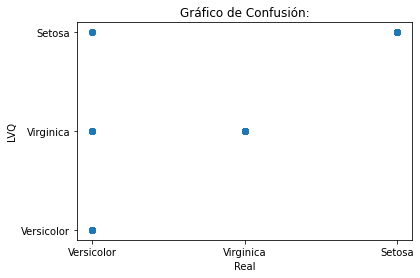

In [13]:
#@title Evaluar RNA LVQ usando datos de Entrenamiento

mostrar_detalle_entrenamiento = False #@param {type:"boolean"}

probarModeloLVQ(rnaLVQ, x_train, y_train, CLASES, mostrar_detalle_entrenamiento)



 Reporte de Clasificación: 
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        15
  Versicolor       1.00      0.67      0.80        15
   Virginica       0.76      1.00      0.86        16

    accuracy                           0.89        46
   macro avg       0.92      0.89      0.89        46
weighted avg       0.92      0.89      0.89        46


Matriz de Confusión: ( real / modelo ): 
              m:na  m:Setosa  m:Versicolor  m:Virginica
r:na             0         0             0            0
r:Setosa         0        15             0            0
r:Versicolor     0         0            10            5
r:Virginica      0         0             0           16




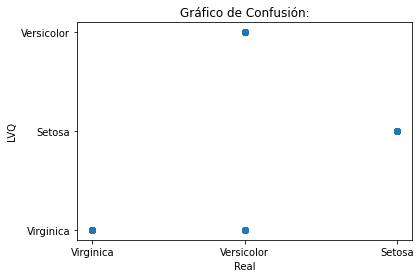

In [14]:
#@title Evaluar RNA LVQ usando datos de Prueba
mostrar_detalle_prueba = False #@param {type:"boolean"}

probarModeloLVQ(rnaLVQ, x_test, y_test, CLASES, mostrar_detalle_prueba)
